# load and import all data

In [1]:
import pandas as pd
import pickle

X_train = pd.read_pickle("X_train.pickle")
y_train = pickle.load(open('y_train.pickle', 'rb'))
X_test = pd.read_pickle("X_test.pickle")
y_test = pd.read_pickle("y_test.pickle")

X_train_rfc = pd.read_pickle("X_train_rfc.pickle")
X_train_adb = pd.read_pickle("X_train_adb.pickle")
X_train_gbc = pd.read_pickle("X_train_gbc.pickle")
X_train_etc = pd.read_pickle("X_train_etc.pickle")
X_train_svc = pd.read_pickle("X_train_svc.pickle")

random = 42
# Read Example Code
# rfc_read = pickle.load(open('rfc.sav', 'rb'))
# df_3601features_read = pd.read_pickle('df_3601features.pickle')

# helper functions

In [2]:
# helper function to plot ROC curve
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import auc as aauc
from sklearn.metrics import accuracy_score

# Adopted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

def plot_roc(clf, X_test, y_test, name, ax, show_thresholds=False):
    y_pred_rf = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thr = roc_curve(y_test, y_pred_rf)

    ax.plot([0, 1], [0, 1], 'k--');
    ax.plot(fpr, tpr, label='{}, AUC={:.2f}'.format(name, aauc(fpr, tpr)));
    ax.scatter(fpr, tpr);

    if show_thresholds:
        for i, th in enumerate(thr):
            ax.text(x=fpr[i], y=tpr[i], s="{:.2f}".format(th), fontsize=10,
                     horizontalalignment='left', verticalalignment='top', color='black',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.1));

    ax.set_xlabel('False positive rate', fontsize=18);
    ax.set_ylabel('True positive rate', fontsize=18);
    ax.tick_params(axis='both', which='major', labelsize=18);
    ax.grid(True);
    ax.set_title('ROC Curve', fontsize=18)

In [3]:
# use Recursive Feature Elimination to find the best set of features then output as df
from sklearn.feature_selection import RFE
def RFE_with_df_output(X,y,estimator_,n_features_to_select_,step_):
    selector = RFE(estimator=estimator_, n_features_to_select = n_features_to_select_, step=step_)
    selector = selector.fit(X,y)
    X_reduced = X[X.columns[selector.get_support(indices=True)]]
    return X_reduced

In [4]:
# this function counts the total number of combinations for any hyperparameter grid
def hyperparams_total_iteration_counter(hyperparams):
    count = 1
    for n in hyperparams.keys():
        count *= len(hyperparams[n])
    return count

In [5]:
# this function returns a threshold table from 0.1 to 0.9
def threshold_table_from_prob(estimator,X,y):
    proba = estimator.predict_proba(X)[:, 1]
    df_thes_result = pd.DataFrame(columns=['threshold','TP','TN','FP','FN','Type I Error (%)', 'Type II Error (%)','ACC (%)'])
    for thes in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        thes_scores = proba.copy()
        thes_scores[thes_scores > thes] = 1
        thes_scores[thes_scores <= thes] = 0
        thes_scores.astype('int')
        tn, fp, fn, tp = confusion_matrix(y, thes_scores).ravel()
        type1_per = (1. - tp/(tp+fn))*100
        type2_per = (1. - tn/(fp+tn))*100
        accuracy = accuracy_score(y, thes_scores) * 100
        df_thes_result.loc[int(thes*10) - 1] = [thes,tp,tn,fp,fn,type1_per,type2_per,accuracy]
    return df_thes_result

# Assemble the other 4 datasets and put them in the same format as 1year.arff

In [6]:
from scipy.io import arff
import pandas as pd
import numpy as np
import featuretools as ft
from sklearn.preprocessing import StandardScaler

In [7]:
# load data
data = arff.loadarff('2year.arff')
df = pd.DataFrame(data[0])

# define column names
column_names = ['net profit / total assets',
                'total liabilities / total assets',
                'working capital / total assets',
                'current assets / short-term liabilities',
                '[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365',
                'retained earnings / total assets',
                'EBIT / total assets',
                'book value of equity / total liabilities',
                'sales / total assets',
                'equity / total assets',
                '(gross profit + extraordinary items + financial expenses) / total assets',
                'gross profit / short-term liabilities',
                '(gross profit + depreciation) / sales',
                '(gross profit + interest) / total assets',
                '(total liabilities * 365) / (gross profit + depreciation)',
                '(gross profit + depreciation) / total liabilities',
                'total assets / total liabilities',
                'gross profit / total assets',
                'gross profit / sales',
                '(inventory * 365) / sales',
                'sales (n) / sales (n-1)',
                'profit on operating activities / total assets',
                'net profit / sales',
                'gross profit (in 3 years) / total assets',
                '(equity - share capital) / total assets',
                '(net profit + depreciation) / total liabilities',
                'profit on operating activities / financial expenses',
                'working capital / fixed assets',
                'logarithm of total assets',
                '(total liabilities - cash) / sales',
                '(gross profit + interest) / sales',
                '(current liabilities * 365) / cost of products sold',
                'operating expenses / short-term liabilities',
                'operating expenses / total liabilities',
                'profit on sales / total assets',
                'total sales / total assets',
                '(current assets - inventories) / long-term liabilities',
                'constant capital / total assets',
                'profit on sales / sales',
                '(current assets - inventory - receivables) / short-term liabilities',
                'total liabilities / ((profit on operating activities + depreciation) * (12/365))',
                'profit on operating activities / sales',
                'rotation receivables + inventory turnover in days',
                '(receivables * 365) / sales',
                'net profit / inventory',
                '(current assets - inventory) / short-term liabilities',
                '(inventory * 365) / cost of products sold',
                'EBITDA (profit on operating activities - depreciation) / total assets',
                'EBITDA (profit on operating activities - depreciation) / sales',
                'current assets / total liabilities',
                'short-term liabilities / total assets',
                '(short-term liabilities * 365) / cost of products sold)',
                'equity / fixed assets',
                'constant capital / fixed assets',
                'working capital',
                '(sales - cost of products sold) / sales',
                '(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)',
                'total costs /total sales',
                'long-term liabilities / equity',
                'sales / inventory',
                'sales / receivables',
                '(short-term liabilities *365) / sales',
                'sales / short-term liabilities',
                'sales / fixed assets',
                'bankrupcy']

# replace column names
df.columns = column_names

# replace label column values to 0 or 1
df.bankrupcy = df.bankrupcy.map({b'0': 0, b'1': 1})

# drop entirely duplicated rows
df.drop_duplicates(inplace=True)

# reset index
df.reset_index(inplace=True,drop=True)

# isolate rows without null
df_std = df[list(df)].copy()
df_std = df_std[df_std.notnull().all(axis=1)]

# reset index
df_std.reset_index(inplace=True,drop=True)

# reformat label column to int64
df_std.bankrupcy = df_std.bankrupcy.astype('int64')

# spliting data into X and y
X = df_std[column_names[:-1]].copy()

# remove correlated feature pairs but one when they have 0.9 or higher MIC score 
features_to_remove = ['(gross profit + interest) / total assets', 
                      'gross profit / total assets', 
                      'net profit / total assets', 
                      '(gross profit + extraordinary items + financial expenses) / total assets', 
                      'total assets / total liabilities', 'book value of equity / total liabilities', 
                      'equity / total assets', 
                      '(gross profit + depreciation) / total liabilities', 
                      '(net profit + depreciation) / total liabilities', 
                      'sales / short-term liabilities', 'sales / receivables', 
                      'sales / inventory', 
                      '(short-term liabilities * 365) / cost of products sold)', 
                      'operating expenses / short-term liabilities', 'net profit / sales', 
                      '(gross profit + interest) / sales', 
                      'EBITDA (profit on operating activities - depreciation) / sales', 
                      'constant capital / fixed assets']
X = X.drop(axis=1, labels=features_to_remove)

# use feature tools to generate more features
# Make an entityset and add the entity
es = ft.EntitySet(id = 'bankruptcy')
es.entity_from_dataframe(entity_id = 'data', dataframe = X, 
                         index = 'index')

# Run deep feature synthesis with transformation primitives
%time feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'data',trans_primitives = ['add_numeric', 'multiply_numeric','divide_numeric','subtract_numeric'],max_depth = 1,chunk_size=.01,n_jobs = -1)

df_5221features = feature_matrix.copy()

df_3601features_read = pd.read_pickle('df_3601features.pickle')

df_5221features = df_5221features[list(df_3601features_read)]

# discover the remaining amount of features
print(df_5221features.shape[1])

2020-02-18 15:14:51,713 featuretools.entityset - WARNING    index index not found in dataframe, creating new integer column
EntitySet scattered to 4 workers in 5 seconds
Wall time: 4min 16s
3601


In [8]:
important_features = list(X_train_rfc) + list(X_train_adb) + list(X_train_gbc) + list(X_train_etc) + list(X_train_svc)
important_features = list(dict.fromkeys(important_features))
df_5221 = df_5221features[important_features]
df_5221.replace(to_replace= [np.inf, -np.inf], value = np.nan,inplace=True)

# isolate rows without null
df_5221 = df_5221[df_5221.notnull().all(axis=1)]

# Standardize every remaining feature
features = list(df_5221)
scaler = StandardScaler().fit(df_5221[features])
df_5221[features] = scaler.transform(df_5221[features])

X_y2_rfc = df_5221[list(X_train_rfc)]
X_y2_adb = df_5221[list(X_train_adb)]
X_y2_gbc = df_5221[list(X_train_gbc)]
X_y2_etc = df_5221[list(X_train_etc)]
X_y2_svc = df_5221[list(X_train_svc)]
y_y2 = df_std[['bankrupcy']].copy().iloc[df_5221.index]

# Trying to predict the other 4 datasets

In [10]:
rfc = pickle.load(open('rfc.sav', 'rb'))
adb = pickle.load(open('adb.sav', 'rb'))
gbc = pickle.load(open('gbc.sav', 'rb'))
etc = pickle.load(open('etc.sav', 'rb'))
svc = pickle.load(open('svc.sav', 'rb'))
xgb_5 = pickle.load(open('xgb_5.sav', 'rb'))


%time rfc_y2_prediction_proba = rfc.predict_proba(X_y2_rfc)[:, 1]
%time adb_y2_prediction_proba = adb.predict_proba(X_y2_adb)[:, 1]
%time gbc_y2_prediction_proba = gbc.predict_proba(X_y2_gbc)[:, 1]
%time etc_y2_prediction_proba = etc.predict_proba(X_y2_etc)[:, 1]
%time svc_y2_prediction_proba = svc.predict_proba(X_y2_svc)[:, 1]

X_test_lvl_2 = pd.DataFrame(data={'Random Forest':rfc_y2_prediction_proba,
                                   'AdaBoost':adb_y2_prediction_proba,
                                   'GradientBoost':gbc_y2_prediction_proba,
                                   'Extra Forest':etc_y2_prediction_proba,
                                   'SVM':svc_y2_prediction_proba,
                                  })

Wall time: 229 ms
Wall time: 878 ms
Wall time: 32 ms
Wall time: 108 ms
Wall time: 1.3 s


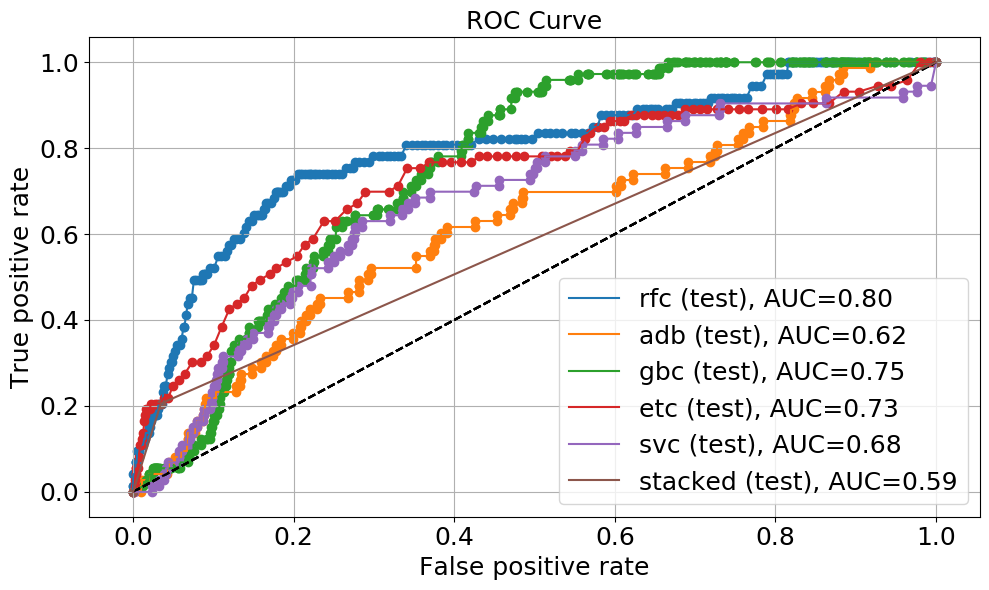

In [14]:
# draw out a ROC curve on the retrained model by comparing predictions with y_test
import matplotlib.pyplot as plt
plt.style.use('default');
figure = plt.figure(figsize=(10, 6));   
ax = plt.subplot(1, 1, 1);
plot_roc(rfc, X_y2_rfc , y_y2, "rfc (test)", ax)
plot_roc(adb, X_y2_adb , y_y2, "adb (test)", ax)
plot_roc(gbc, X_y2_gbc , y_y2, "gbc (test)", ax)
plot_roc(etc, X_y2_etc , y_y2, "etc (test)", ax)
plot_roc(svc, X_y2_svc , y_y2, "svc (test)", ax)
plot_roc(xgb_5, X_test_lvl_2 , y_y2, "stacked (test)", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();

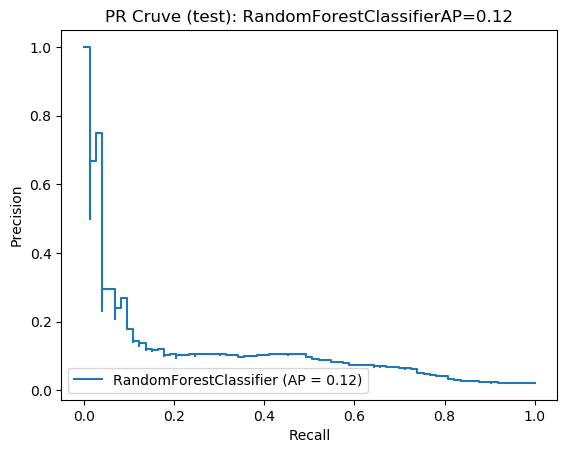

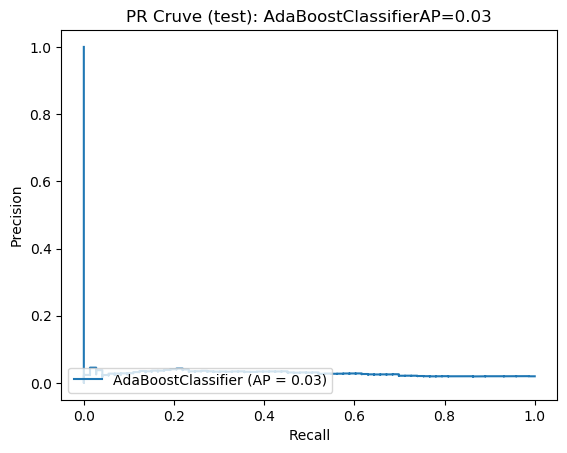

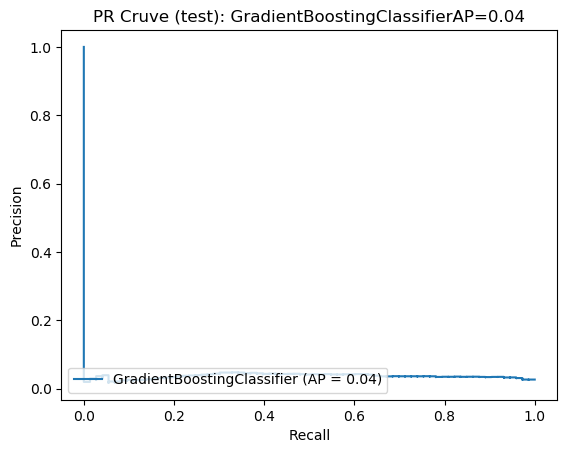

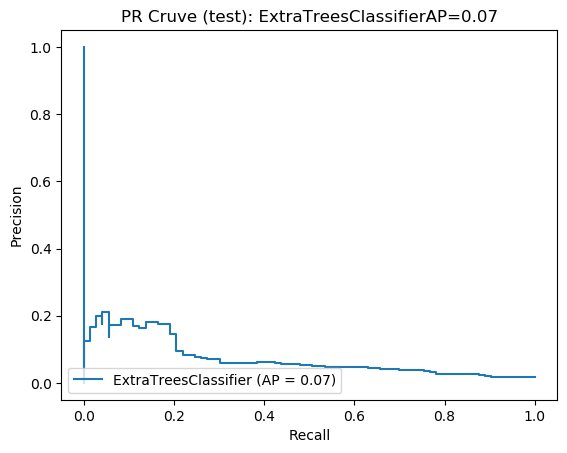

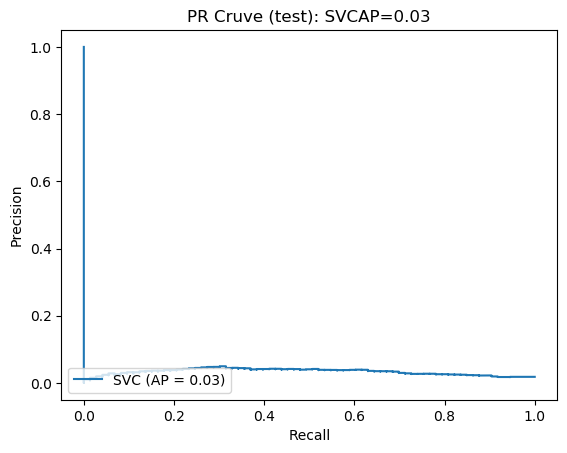

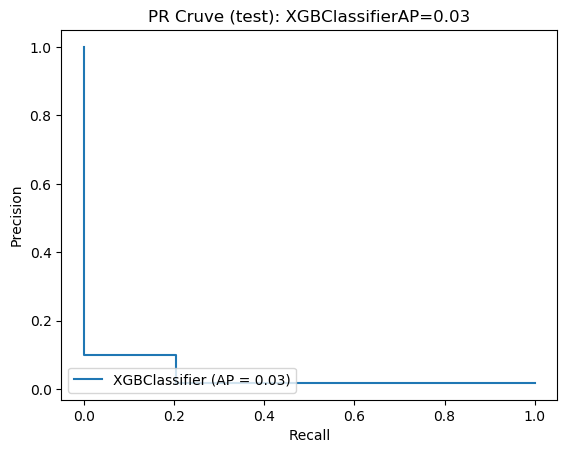

In [24]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

def pr_curve(estimator,X,y_true):
    y_score = estimator.predict_proba(X)[:, 1]
    average_precision = average_precision_score(y_true, y_score)
    disp = plot_precision_recall_curve(estimator, X, y_true)
    disp.ax_.set_title('PR Cruve (test): ' + str(estimator).split('(')[0] +
                       'AP={0:0.2f}'.format(average_precision))

estimators = [rfc,adb,gbc,etc,svc,xgb_5]
Xs = [X_y2_rfc,X_y2_adb,X_y2_gbc,X_y2_etc,X_y2_svc,X_test_lvl_2]

for index in range(0,len(estimators)):
    pr_curve(estimators[index],Xs[index],y_y2)

In [25]:
# musical checkpoint :P
import IPython
IPython.display.Audio('finished!.mp3',autoplay=True)